## CLASSIFICATION MODEL

The goal of the final part is to create a model that predicts if a car collision with certain set of parameters or circumstances results in anybody's death or severe injuries. To create this model I use California Traffic Collision Data from SWITRS (2001 - 2020), filtered since 2014. Although this dataset provides very detailed information about each collision happened in California during the last 7 years, some of the details are useless or excessive. Therefore, dataset requires accurate preprocessing to be used in model training.

In [2]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import category_encoders as ce
from collections import Counter

from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.model_selection import GridSearchCV


In [3]:
zf = zipfile.ZipFile('california_df.zip')
california_df = pd.read_csv(zf.open('california_df.csv'))

california_df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (21,24,25,27,29,36,49,57,67,68) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,case_id,jurisdiction,officer_id,reporting_district,chp_shift,population,county_city_location,special_condition,beat_type,chp_beat_type,...,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,primary_ramp,secondary_ramp,latitude,longitude,collision_date,collision_time,process_date
0,726202,3600.0,8945,064,5,5,3612,0,0,not chp,...,0,0,0,NaN,NaN,NaN,NaN,2020-07-26,02:50:00,2020-09-30
1,5816493,1502.0,00001,NaN,5,6,1502,0,0,not chp,...,0,0,0,NaN,NaN,35.38353,-119.10416,2014-05-23,21:38:00,2014-07-30
2,5816498,5606.0,00001,NaN,5,4,5606,0,0,not chp,...,0,0,0,NaN,NaN,34.35117,-119.06705,2014-01-04,19:26:00,2014-03-03
3,5816553,1942.0,33260,123,5,7,1942,0,0,not chp,...,0,0,0,NaN,NaN,NaN,NaN,2014-05-19,09:00:00,2014-05-31
4,5816557,1948.0,20767,NaN,5,5,1948,0,0,not chp,...,0,0,0,NaN,NaN,34.42196,-118.65565,2014-04-17,07:55:00,2014-05-30


## MANUAL FEATURE SELECTION

The first step is to exclude certain columns manually based on my view what can be used in model that predicts accident's outcome. Initially, there are 74 columns: 1 - target column 'collision severity', 73 - independent features.

What kind of information might be useless for a model? Individual numbers, duplicating features like territory codes that provide information about collision's location already provided by other columns. Also, features about post - collision events, for instance, number of killed or injured, if there was tow-away etc.

**Columns to drop - PART I:**

- case_id - individual number of accident;
- jurisdiction - correspond to county_city_location feature;
- officer_id - individual number of an officer;
- reporting_district - information about location of the accident provided by county_city_location feature;
- chp_shift - California Highway Patrol shift, not valuable information;
- city_division_lapd - Los Angeles police department, too limited information;
- caltrans_county - information about location of the accident provided by county_city_location feature;
- caltrans_district - information about location of the accident provided by county_city_location feature;
- beat_number - no idea what is that;
- tow_away - post-accident information;
- killed_victims - post-accident information;
- injured_victims - post-accident information;
- hit_and_run - post-accident information;
- not_private_property - indicates whether the collision occurred on private property, not so important information;
- severe_injury_count - post-accident information;
- other_visible_injury_count - post-accident information;
- complaint_of_pain_injury_count - post-accident information;
- pedestrian_killed_count - post-accident information;
- pedestrian_injured_count - post-accident information;
- bicyclist_killed_count - post-accident information;
- bicyclist_injured_count - post-accident information;
- motorcyclist_killed_count - post-accident information;
- motorcyclist_injured_count - post-accident information;
- process_date - post-accident information.


In [4]:
columns_to_drop = ['case_id', 'jurisdiction','officer_id','reporting_district','chp_shift','city_division_lapd',
                   'caltrans_county','caltrans_district','tow_away','killed_victims','injured_victims',
                   'hit_and_run','not_private_property','severe_injury_count','other_visible_injury_count',
                   'complaint_of_pain_injury_count','pedestrian_killed_count','pedestrian_injured_count',
                   'bicyclist_killed_count','bicyclist_injured_count','motorcyclist_killed_count',
                   'motorcyclist_injured_count','process_date', 'beat_number']

crashes = california_df.drop(columns = columns_to_drop).copy()

Next step to decide which columns to use is to count amount of missing values in all features. Following features contain mainly cells with missing values.

**Columns to drop - PART II (MISSING VALUES):**

In [5]:
crashes.isna().sum().sort_values(ascending = False)

pcf_violation_code                 3015671
route_suffix                       3015513
road_condition_2                   3000702
primary_ramp                       2994181
secondary_ramp                     2993779
weather_2                          2936611
bicycle_collision                  2933391
ramp_intersection                  2930739
postmile_prefix                    2927031
pedestrian_collision               2919589
motorcycle_collision               2906985
truck_collision                    2840189
alcohol_involved                   2715324
side_of_highway                    2710933
postmile                           2710918
location_type                      2710917
state_route                        2710917
pcf_violation_subsection           1942157
latitude                           1294212
longitude                          1294211
direction                           720519
chp_vehicle_type_at_fault           576384
statewide_vehicle_type_at_fault     535983
pcf_violati

Not needed features because they contain too many cells with missing data:

- road_condition_2;
- primary_ramp;
- secondary_ramp;
- route_suffix;
- postmile_prefix;
- weather_2;
- pcf_violation_code - duplicate information from pcf_violation_category;
- state_route - duplicate information from column State Highway Indicator;
- postmile - suppose it does not influence the probability of collision and its outcome;
- ramp_intersection;
- side_of_highway - suppose it duplicates direction feature;
- pcf_violation_subsection - suppose this information is not so valuable because pcf_violation_category provides more general information about accident;
- statewide_vehicle_type_at_fault - post-accident information: whose fault was that;
- chp_vehicle_type_at_fault - post-accident information: whose fault was that;
- pcf_violation - duplicates pcf_violation_category;
- latitude - too detailed information about place of accidents, also, model's goal to find circumstances that influence probability of certain outcome, not the exact place of future collisions;
- longitude.




In [6]:
columns_to_drop_2 = ['road_condition_2','primary_ramp','secondary_ramp', 'route_suffix', 'postmile_prefix',
                    'weather_2', 'pcf_violation_code', 'state_route', 'postmile', 'ramp_intersection',
                     'side_of_highway', 'pcf_violation_subsection', 'statewide_vehicle_type_at_fault',
                     'chp_vehicle_type_at_fault', 'pcf_violation', 'latitude', 'longitude']

crashes = crashes.drop(columns = columns_to_drop_2)

In [7]:
crashes.shape

(3015847, 33)

**Columns to drop - PART III:**

- primary_road - too many variables that should be used in pair with county_city_location codes, but this approach results in very high cardinality of categories in a combined feature;
- secondary_road;
- beat_type - duplicates information in column chp_beat_type;
- chp_beat_class - provides less detailed information than chp_beat_type.


In [8]:
columns_to_drop_3 = ['primary_road', 'secondary_road', 'beat_type', 'chp_beat_class']

crashes = crashes.drop(columns = columns_to_drop_3)

Check missing values one more time.

In [9]:
crashes.isna().sum().sort_values(ascending = False)

bicycle_collision              2933391
pedestrian_collision           2919589
motorcycle_collision           2906985
truck_collision                2840189
alcohol_involved               2715324
location_type                  2710917
direction                       720519
collision_time                   28256
type_of_collision                26647
pcf_violation_category           25548
road_surface                     18315
road_condition_1                 18119
control_device                   17645
intersection                     17365
motor_vehicle_involved_with      15891
lighting                         11865
primary_collision_factor          8967
weather_1                         8724
pedestrian_action                 2213
state_highway_indicator            667
collision_severity                  16
distance                             1
chp_road_type                        0
county_city_location                 0
party_count                          0
chp_beat_type            

There are still several columns with significant amount of cells with missing values, but they can be corrected based on information provided in [dictionary](https://tims.berkeley.edu/help/SWITRS.php) of the dataset.

In [10]:
# these columns have 2 options: Y (YES) or blank, therefore, NaN values = 0 or NO
y_or_blank = ['pedestrian_collision', 'bicycle_collision', 'motorcycle_collision', 'truck_collision', 'alcohol_involved']

crashes[y_or_blank] = crashes[y_or_blank].fillna(0)

# for column direction blank = 'not stated'
crashes['direction'] = crashes['direction'].fillna('not stated')

# for column location_type blank = 'Not State Highway (NSH)'
crashes['location_type'] = crashes['location_type'].fillna('NSH')

In [11]:
print('Proportion of rows with missing values per each feature:')
np.round((crashes.isna().sum().sort_values(ascending = False))/len(crashes), 4)

Proportion of rows with missing values per each feature:


collision_time                 0.0094
type_of_collision              0.0088
pcf_violation_category         0.0085
road_surface                   0.0061
road_condition_1               0.0060
control_device                 0.0059
intersection                   0.0058
motor_vehicle_involved_with    0.0053
lighting                       0.0039
primary_collision_factor       0.0030
weather_1                      0.0029
pedestrian_action              0.0007
state_highway_indicator        0.0002
collision_severity             0.0000
distance                       0.0000
alcohol_involved               0.0000
pedestrian_collision           0.0000
motorcycle_collision           0.0000
bicycle_collision              0.0000
collision_date                 0.0000
truck_collision                0.0000
special_condition              0.0000
chp_road_type                  0.0000
chp_beat_type                  0.0000
county_city_location           0.0000
party_count                    0.0000
location_typ

In [12]:
# I suppose that proportion of samples with missing values is so small
# that I can easily drop these rows without damaging future model's performance.

crashes = crashes.dropna()
crashes.shape

(2864092, 29)

## MANUAL FEATURE ENGINEERING

In [13]:
# dataset provides information about exact day and time.
# I presume that year of collision does not play role, but month and day of week do.
# Also, I extract hour of collision because it might be essential for model.

# month
crashes['collision_month'] = pd.to_datetime(crashes.collision_date).dt.month

#day of week
crashes['collision_day'] = pd.to_datetime(crashes.collision_date).dt.dayofweek

#hour
crashes['collision_hour'] = pd.to_datetime(crashes.collision_time, format='%H:%M:%S').dt.hour

crashes = crashes.drop(['collision_date', 'collision_time'], axis = 1)
crashes.head()

,population,county_city_location,special_condition,chp_beat_type,distance,direction,intersection,weather_1,state_highway_indicator,location_type,...,control_device,chp_road_type,pedestrian_collision,bicycle_collision,motorcycle_collision,truck_collision,alcohol_involved,collision_month,collision_day,collision_hour
1,6,1502,0,not chp,25.0,east,0.0,clear,0.0,NSH,...,functioning,0,0.0,0.0,0.0,0.0,0.0,5,4,21
2,4,5606,0,not chp,60.0,west,0.0,clear,0.0,NSH,...,none,0,0.0,0.0,0.0,0.0,0.0,1,5,19
3,7,1942,0,not chp,300.0,south,0.0,clear,0.0,NSH,...,none,0,0.0,0.0,0.0,0.0,0.0,5,0,9
4,5,1948,0,not chp,100.0,north,0.0,cloudy,0.0,NSH,...,none,0,0.0,0.0,0.0,0.0,0.0,4,3,7
6,6,1992,0,not chp,32.0,east,0.0,clear,0.0,NSH,...,none,0,1.0,0.0,0.0,0.0,1.0,1,4,22


In [14]:
print('So, there are {} feature-columns and 1 target-column.'.format(len(crashes.columns)-1))
crashes.columns

So, there are 29 feature-columns and 1 target-column.


Index(['population', 'county_city_location', 'special_condition',
       'chp_beat_type', 'distance', 'direction', 'intersection', 'weather_1',
       'state_highway_indicator', 'location_type', 'collision_severity',
       'party_count', 'primary_collision_factor', 'pcf_violation_category',
       'type_of_collision', 'motor_vehicle_involved_with', 'pedestrian_action',
       'road_surface', 'road_condition_1', 'lighting', 'control_device',
       'chp_road_type', 'pedestrian_collision', 'bicycle_collision',
       'motorcycle_collision', 'truck_collision', 'alcohol_involved',
       'collision_month', 'collision_day', 'collision_hour'],
      dtype='object')

## STATISTICAL FEATURE SELECTION

Statistical-based feature selection techniques are used to eveluate how strong relationships are between target variable and each of independent variables. There are several statistical methods and choice which one to apply depends on kinds of input and output variables. I apply Chi-squared test that can be used for feature selection when input and output are categorical.

In [15]:
# I create separate dataframe for statistical analysis because I do not want to change original dataframe yet.
# This analysis will not be used to transform original dataframe crashes, but to detect features with strong relationships with target.

crashes_chi = crashes.copy()
crashes_chi.head()

,population,county_city_location,special_condition,chp_beat_type,distance,direction,intersection,weather_1,state_highway_indicator,location_type,...,control_device,chp_road_type,pedestrian_collision,bicycle_collision,motorcycle_collision,truck_collision,alcohol_involved,collision_month,collision_day,collision_hour
1,6,1502,0,not chp,25.0,east,0.0,clear,0.0,NSH,...,functioning,0,0.0,0.0,0.0,0.0,0.0,5,4,21
2,4,5606,0,not chp,60.0,west,0.0,clear,0.0,NSH,...,none,0,0.0,0.0,0.0,0.0,0.0,1,5,19
3,7,1942,0,not chp,300.0,south,0.0,clear,0.0,NSH,...,none,0,0.0,0.0,0.0,0.0,0.0,5,0,9
4,5,1948,0,not chp,100.0,north,0.0,cloudy,0.0,NSH,...,none,0,0.0,0.0,0.0,0.0,0.0,4,3,7
6,6,1992,0,not chp,32.0,east,0.0,clear,0.0,NSH,...,none,0,1.0,0.0,0.0,0.0,1.0,1,4,22


In [16]:
# target column - collision severity has 5 categories: from lightest 'property damage only' to the worst 'fatal'.
# I replace these categories with 1 - fatal & severe injury, 0 - others.

target_map = {'property damage only': 0, 'pain': 0,'other injury': 0,'severe injury': 1, 'fatal' :1}

crashes_chi['collision_severity'] = crashes_chi['collision_severity'].map(target_map)

crashes_chi.collision_severity.value_counts()

0    2766299
1      97793
Name: collision_severity, dtype: int64

In [17]:
# target variable
target = crashes_chi[['collision_severity']]

#columns with numeric data
X_num = crashes_chi[['distance','party_count']]

#columns with categorical data
X_cat = crashes_chi.drop(columns = ['distance','party_count','collision_severity'])


In [18]:
target.shape, X_num.shape, X_cat.shape

((2864092, 1), (2864092, 2), (2864092, 27))

### Chi-squared test

**Chi-squared test** - statistical test to evaluate relationship between categorical features or, in this case, between input and output variables. The idea of this test is to compare observed distribution of categories with expected distribution which was calculated under assumption that two categorical features are independent. The test statistic Chi-squared indicates how far the observed frequencies are from expected. If Chi-squared is large, spesifically, larger than certain critical value (calculated based on significance level and degree of freedom), then, variables are dependent.


The purpose of Chi-squared test is not only to detect dependencies, but also to identify which categorical features have the strongest relationship with target variable, so, to use them in model training.

In [19]:
def prepare_inputs(X):
    oe = OrdinalEncoder()
    oe.fit(X)
    X_enc = oe.transform(X)

    return X_enc

X_cat = X_cat.astype(str)
X_cat_enc = prepare_inputs(X_cat)

Feature 0 - "population": 2414.30
Feature 1 - "county_city_location": 129533.21
Feature 2 - "special_condition": 262.91
Feature 3 - "chp_beat_type": 246.11
Feature 4 - "direction": 1.12
Feature 5 - "intersection": 61.01
Feature 6 - "weather_1": 242.36
Feature 7 - "state_highway_indicator": 256.59
Feature 8 - "location_type": 185.79
Feature 9 - "primary_collision_factor": 1.67
Feature 10 - "pcf_violation_category": 17152.21
Feature 11 - "type_of_collision": 16328.34
Feature 12 - "motor_vehicle_involved_with": 82.27
Feature 13 - "pedestrian_action": 2607.41
Feature 14 - "road_surface": 20.09
Feature 15 - "road_condition_1": 5.74
Feature 16 - "lighting": 5270.43
Feature 17 - "control_device": 6.96
Feature 18 - "chp_road_type": 1177.30
Feature 19 - "pedestrian_collision": 80276.41
Feature 20 - "bicycle_collision": 8223.63
Feature 21 - "motorcycle_collision": 92612.26
Feature 22 - "truck_collision": 0.51
Feature 23 - "alcohol_involved": 20463.27
Feature 24 - "collision_month": 378.60
Featur

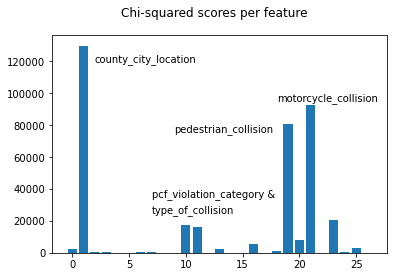

In [20]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_cat_enc, target)

column_names_cat = X_cat.columns

for i, column in zip(range(len(fs.scores_)), column_names_cat):
    print('Feature {} - "{}": {:.2f}'.format(i, column, fs.scores_[i]))

# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.suptitle('Chi-squared scores per feature', fontsize = 12)
plt.text(2, 120000, 'county_city_location')
plt.text(7, 35000, 'pcf_violation_category &')
plt.text(7, 25000, 'type_of_collision')
plt.text(9, 76000, 'pedestrian_collision')
plt.text(18, 95000, 'motorcycle_collision')
plt.show()

In [21]:
selected_features = ['population', 'county_city_location', 'special_condition','chp_beat_type',
                     'weather_1', 'state_highway_indicator', 'pcf_violation_category', 'type_of_collision',
                     'pedestrian_action', 'lighting', 'chp_road_type', 'pedestrian_collision',
                     'bicycle_collision', 'motorcycle_collision', 'alcohol_involved', 'collision_day','collision_month']

In [22]:
#select 17 categorical features and 2 numerical features

crashes = crashes[['population', 'county_city_location', 'special_condition','chp_beat_type',
                     'weather_1', 'state_highway_indicator', 'pcf_violation_category', 'type_of_collision',
                     'pedestrian_action', 'lighting', 'chp_road_type', 'pedestrian_collision',
                     'bicycle_collision', 'motorcycle_collision', 'alcohol_involved', 'collision_day',
                   'collision_month', 'distance','party_count']]

crashes.shape

(2864092, 19)

## ENCODING CATEGORICAL FEATURES

Most machine learning algorithms accept only numerical values, therefore, categorical variables should be converted into numbers. There are various methods of encoding categorical features in a way that saves valuable information. For different categorical features I use following techniques:


- label encoding (from 0 to n-1, where n - number of categories);

- binary encoding (category converted into number, then transformed in the binary number, then split into different columns);

- target encoding (replace category with posterior probability of the target for each category, might reduce number of categories).

### COLUMNS 1 - 10:

- population: categories from 1 (Incorporated (less than 2500)) to 9 (Unincorporated (Rural));
- county_city_location: code consisting of 2 parts, first 2 firgures - one of 58 counties in California;
- special_condition: 0 (no condition) or 1 (Schoolbus on Public Roadway);
- chp_beat_type: 8 categories like interstate, state route or us highway etc.;
- weather_1: 7 categories - clear, cloudy, fog, raining, snowing, other, wind;
- state_highway_indicator: 1 - state highway, 0 - not state highway;
- pcf_violation_category: 22 categories;
- type_of_collision: 10 categories like rear end, sideswipe, overturned etc.;
- pedestrian_action: 7 categories - no pedestrian involved, crossing not in crosswalk etc.;
- lighting: 5 categories like daylight, dark with street lights etc.


In [23]:
# population variable is already encoded (ordinal categorical variable), BUT category '9' should be replaced with '0',
# because '9' - is the smallest category (rural territory)

crashes['population'] = crashes['population'].replace(9, 0)
crashes.population.value_counts()

0    732933
7    702930
6    534859
5    493247
4    241638
3    109337
2     35030
1     14118
Name: population, dtype: int64

In [24]:
# county_city_location: 541 categories, code consisting of 2 parts, first 2 firgures - one of 58 counties in California;
# apply target encoding, number of categories decreases from 541 to 518

#Create target encoding object
encoder=ce.TargetEncoder(cols='county_city_location') 

crashes = encoder.fit_transform(crashes, target)

crashes.county_city_location.value_counts()

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.029825    337266
0.032119    121205
0.035713     64570
0.040700     60565
0.024410     44899
             ...  
0.197017         5
0.009183         4
0.001619         4
0.591268         3
0.374712         2
Name: county_city_location, Length: 518, dtype: int64

In [25]:
# special_condition is already encoded - binary
crashes.special_condition.value_counts()

0    2852882
1      11210
Name: special_condition, dtype: int64

In [26]:
# chp_beat_type (nominal variable) has 8 categories.
# As there are a lot of categorical variables I try not to increase number of columns per each categorical variable.

# apply target encoding
encoder=ce.TargetEncoder(cols='chp_beat_type') 

crashes = encoder.fit_transform(crashes, target)

crashes.chp_beat_type.value_counts()

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.031600    1372485
0.023223     548593
0.042109     400863
0.053388     264573
0.049073     138833
0.028263     122314
0.022599      15089
0.049180       1342
Name: chp_beat_type, dtype: int64

In [27]:
# state_highway_indicator is already encoded - binary
crashes.state_highway_indicator.value_counts()

0.0    1676703
1.0    1187389
Name: state_highway_indicator, dtype: int64

In [28]:
# I suppose weather variable is one important and I do not want to reduce number of categories appluing target encoding.
# apply binary encoding

encoder = ce.BinaryEncoder(cols=['weather_1'], drop_invariant = True)
crashes = encoder.fit_transform(crashes)

crashes.columns


/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Index(['population', 'county_city_location', 'special_condition',
       'chp_beat_type', 'weather_1_1', 'weather_1_2', 'weather_1_3',
       'state_highway_indicator', 'pcf_violation_category',
       'type_of_collision', 'pedestrian_action', 'lighting', 'chp_road_type',
       'pedestrian_collision', 'bicycle_collision', 'motorcycle_collision',
       'alcohol_involved', 'collision_day', 'collision_month', 'distance',
       'party_count'],
      dtype='object')

In [29]:
# pcf_violation_category has 22 categories and I apply binary encoding to save all categories impact.
# lighting has 5 categories and I apply binary encoding to save all categories impact.

encoder = ce.BinaryEncoder(cols=['pcf_violation_category', 'lighting'], drop_invariant = True)
crashes = encoder.fit_transform(crashes)

crashes.columns

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Index(['population', 'county_city_location', 'special_condition',
       'chp_beat_type', 'weather_1_1', 'weather_1_2', 'weather_1_3',
       'state_highway_indicator', 'pcf_violation_category_1',
       'pcf_violation_category_2', 'pcf_violation_category_3',
       'pcf_violation_category_4', 'pcf_violation_category_5',
       'type_of_collision', 'pedestrian_action', 'lighting_1', 'lighting_2',
       'lighting_3', 'chp_road_type', 'pedestrian_collision',
       'bicycle_collision', 'motorcycle_collision', 'alcohol_involved',
       'collision_day', 'collision_month', 'distance', 'party_count'],
      dtype='object')

In [30]:
# type_of_collision has 10 categories, I apply target encoding

# apply target encoding
encoder=ce.TargetEncoder(cols='type_of_collision') 

crashes = encoder.fit_transform(crashes, target)

crashes.type_of_collision.value_counts()

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.012362    989229
0.012592    551220
0.035714    516326
0.047435    460883
0.075067    124009
0.205895     78977
0.127898     72128
0.049441     71318
0.034145         2
Name: type_of_collision, dtype: int64

In [31]:
# pedestrian_action (nominal variable) has 7 categories, but 97% of all samples are 'no pedestrian involved'.

print(crashes.pedestrian_action.value_counts())
pa = crashes.pedestrian_action.value_counts()[0] / len(crashes)
print('\nPercentage of "no pedestrian involved" category in the feature - {:.2f}%.'.format(pa*100))

no pedestrian involved                 2777191
crossing in intersection crosswalk       39553
crossing not in crosswalk                22815
in road                                  16339
not in road                               6041
crossing non-intersection crosswalk       2121
using school bus                            32
Name: pedestrian_action, dtype: int64

Percentage of "no pedestrian involved" category in the feature - 96.97%.


In [32]:
# apply target encoding
encoder=ce.TargetEncoder(cols='pedestrian_action') 

crashes = encoder.fit_transform(crashes, target)

crashes.pedestrian_action.value_counts()

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.028683    2777191
0.126691      39553
0.296384      22815
0.308832      16339
0.162721       6041
0.155116       2121
0.125000         32
Name: pedestrian_action, dtype: int64

### COLUMNS 11 - 17

- chp_road_type: 8 categories from 0 to 7;
- pedestrian_collision: 1 - YES, 0 - NO;
- bicycle_collision: 1 - YES, 0 - NO;
- motorcycle_collision: 1 - YES, 0 - NO;
- alcohol_involved: 1 - YES, 0 - NO;
- collision_month: months;
- collision_day: day of month.

In [33]:
# chp_road_type is already encoded
crashes.chp_road_type.value_counts()

0    2685121
1     155620
6      11042
0       8062
5       2565
4       1253
3        249
7        167
2         13
Name: chp_road_type, dtype: int64

In [34]:
# pedestrian_collision is already encoded - binary
crashes.pedestrian_collision.value_counts()

0.0    2777191
1.0      86901
Name: pedestrian_collision, dtype: int64

In [35]:
# bicycle_collision is already encoded - binary
crashes.bicycle_collision.value_counts()

0.0    2789121
1.0      74971
Name: bicycle_collision, dtype: int64

In [36]:
# motorcycle_collision is already encoded - binary
crashes.motorcycle_collision.value_counts()

0.0    2759645
1.0     104447
Name: motorcycle_collision, dtype: int64

In [37]:
# alcohol_involved is already encoded - binary
crashes.alcohol_involved.value_counts()

0.0    2579102
1.0     284990
Name: alcohol_involved, dtype: int64

In [38]:
crashes['chp_road_type'] = crashes.chp_road_type.astype('int32')


In [39]:
crashes.shape, target.shape

((2864092, 27), (2864092, 1))

In [40]:
crashes.columns

Index(['population', 'county_city_location', 'special_condition',
       'chp_beat_type', 'weather_1_1', 'weather_1_2', 'weather_1_3',
       'state_highway_indicator', 'pcf_violation_category_1',
       'pcf_violation_category_2', 'pcf_violation_category_3',
       'pcf_violation_category_4', 'pcf_violation_category_5',
       'type_of_collision', 'pedestrian_action', 'lighting_1', 'lighting_2',
       'lighting_3', 'chp_road_type', 'pedestrian_collision',
       'bicycle_collision', 'motorcycle_collision', 'alcohol_involved',
       'collision_day', 'collision_month', 'distance', 'party_count'],
      dtype='object')

In [41]:
target.collision_severity.value_counts()

0    2766299
1      97793
Name: collision_severity, dtype: int64

## Train/test split

For trainig and testing the model dataset should be split into 2 parts: train set and test set. These sets should be equally distributed, so, the partitions of each class in target column in train and test sets should be similar.


In [42]:
X_train, X_test, y_train, y_test = train_test_split(crashes, target, test_size=0.15, random_state = 1, shuffle = True)

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2434478, 27), (429614, 27), (2434478, 1), (429614, 1))

Distribution of classes in train set and test set

Train set:
Class=0, n=2351416 96.588
Class=1, n=83062 3.412

Test set:
Class=0, n=414883 96.571
Class=1, n=14731 3.429


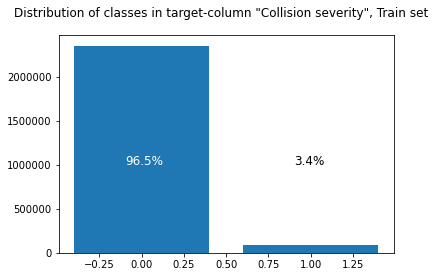

In [44]:
print('Distribution of classes in train set and test set')

print('\nTrain set:')
counter = Counter(y_train['collision_severity'])

for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class={}, n={} {:.3f}'.format(k, v, per))
    
print('\nTest set:')

counter_2 = Counter(y_test['collision_severity'])
for k,v in counter_2.items():
    per = v / len(y_test) * 100
    print('Class={}, n={} {:.3f}'.format(k, v, per))
    
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.suptitle('Distribution of classes in target-column "Collision severity", Train set')
plt.ticklabel_format(useOffset=False, style='plain')
plt.text(-0.1, 1000000, '96.5%', fontsize = 12, color = 'white')
plt.text(0.9, 1000000, '3.4%', fontsize = 12, color = 'black')
plt.show()

Although classes in target column are equally distributed in train in test sets, it is easily noticed on the plot that inside each set classes are not balanced: class - 0 is majority class, class - 1 is minority class.

Imbalanced data is quite a specefic case and requires special preprocessing and algorithms to handle the problem of minority class under-representation.

**IMBALANSED DATA CLASSIFICATION**


Dataset can be called imbalanced when target classes are not equally represented in dataset. In this case minority class constitutes very small percent of all samples. It might happen in medical datasets (percentage of people diagnosed positive for some disease in a large group of people might be very low) or in production (percentage of products defect). The main problem of imbalanced data is poor performance of classification model because there is not enough data to train it. Standard algoritms do not suit here because they assume balanced data, minority samples can be treated as outliers or ignored, so, if algorithms learn how to detect majority class, errors with minority class won't reduce performance metric significantly. Ironically, minority class samples are usually more important to classify correctly.



What can be done with imbalanced data? There are several techniques that can be implemented to handle this problem. I describe what I tried and failed to implement (without code in my GitHub repository because it didn't work for this project) and what I succeded to implement.



1. Undersample the majority class - it reduced significantly the overall training set and resulted in poor performance;

2. Oversample the minority class (manually) - I added copied samples of minority class to increase its partition, but it didn't improve performance;

3. Synthesize new samples for minority class - I tried to use SMOTE-NC algorithm (Synthetic Minority Oversampling TEchnique - Nominal-Continuous), but without success. As it requires at least one continuous feature, I suppose the problem was with numerical features 'distance' and 'party_count';

4. Treat minority class as anomalies and perform anomaly detection instead of classification - I tried to use IsolationForrest algorithm, but it performed poorly;

5. Adjust class weights at the algorithm level and use undersampling inside algorithms - that worked.

## Decision tree classifier

One of the DTC parameters provides modification for imbalanced data - class_weight. Larger weight is assigned to minority class and a smaller weight is assigned to majority class. I chose heuristic way to determine classes weights and set the parameter as 'balanced'. 

In [45]:
dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced')

In [46]:
y_pred = dt.predict(X_test)

result_1 = classification_report(y_test, y_pred)
print('Classification Report:')
print (result_1)

print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97    414883
           1       0.15      0.17      0.16     14731

    accuracy                           0.94    429614
   macro avg       0.56      0.57      0.56    429614
weighted avg       0.94      0.94      0.94    429614

Confusion Matrix: 
[[400041  14842]
 [ 12163   2568]]
Area Under Curve: 0.5692761548383451


**Precision: When it predicts yes, how often is it correct?**

**Recall: When it's actually yes, how often does it predict yes?**

**F1-score:  harmonic mean of the precision and recall.**


High accuracy clearly demostrates what I wrote above: great results for class-0 and poor results for class-1 in total give high accuracy. That is why accuracy is not the best metric to evaluate model's performance in case of imbalanced data. I should remind that class-1 indicates car collisions with killed and injured victims and is much more important for classification. 

## Balanced Random Forest Classifier

It is a modification of Random Forest that performs data resampling with undersampling of the majority class on the bootstrap sample in order to explicitly change the class distribution. Parameter class-weight =  'balanced_subsample' enables an option to compute weights based on bootstrap sample for every tree grown. 

In [47]:
# define model, balanced_subsample - weights are computed based on the bootstrap sample for every tree
model_2 = BalancedRandomForestClassifier(n_estimators=10, class_weight = 'balanced_subsample')
model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
result_2 = classification_report(y_test, y_pred_2)
print('Classification Report:')
print (result_2)

print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_2)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_2)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88    414883
           1       0.11      0.73      0.19     14731

    accuracy                           0.79    429614
   macro avg       0.55      0.76      0.53    429614
weighted avg       0.96      0.79      0.85    429614

Confusion Matrix: 
[[327322  87561]
 [  3935  10796]]
Area Under Curve: 0.7609131925595859


Area Under Curve (AUC) is a useful metric for imbalanced data classification and represents the degree of classes  separability. It is equal to the probability that a random positive sample will be ranked above a random negative sample.


This model performes much better. Although the precision of class-1 is only 0.11, higher amount of actually predicted class-1 samples is more valuable.

## Easy Ensemble Classifier

It provides an implementation of the easy ensemble technique: create multiple datasets with all of the examples in the minority class and random resampling of the majority class. This technique might be seen as a type of undersampling.

In [49]:
# define model
model_3 = EasyEnsembleClassifier(n_estimators=20)
model_3.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


EasyEnsembleClassifier(n_estimators=20)

In [50]:
y_pred_3 = model_3.predict(X_test)

result_3 = classification_report(y_test, y_pred_3)
print('Classification Report:')
print (result_3)

print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_3)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_3)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.88    414883
           1       0.12      0.75      0.20     14731

    accuracy                           0.79    429614
   macro avg       0.55      0.77      0.54    429614
weighted avg       0.96      0.79      0.86    429614

Confusion Matrix: 
[[330039  84844]
 [  3696  11035]]
Area Under Curve: 0.7722997541416808


EasyEnsemble classifier performes a little bit better: higher number of truly predicted class-1 samples, lower number of false predicted samples in both classes.

In [51]:
y_train_s = y_train['collision_severity']
y_train_s.shape

(2434478,)

In [52]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model
scores = cross_val_score(model_3, X_train, y_train_s, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.850


## XGBoost Classifier

It is an ensemble algorithm where new trees fix errors of those trees that are already part of the model. Trees are added until no further improvements can be made to the model. To handle the problem of imbalanced data, the parameter scale_pos_weight is used which turns XGBoost Classifier in a class-weighted version of algorithm. I applied Grid Search algorithm to identify the best option for scale_pos_weight parameter.

In [53]:
model_4 = XGBClassifier(scale_pos_weight=50, use_label_encoder=False)
model_4.fit(X_train, y_train)

[09:55:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=50, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [54]:
y_pred_4 = model_4.predict(X_test)

In [55]:
result_4 = classification_report(y_test, y_pred_4)
print('Classification Report:')
print (result_4)

print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_4)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_4)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.68      0.81    414883
           1       0.09      0.87      0.16     14731

    accuracy                           0.69    429614
   macro avg       0.54      0.78      0.48    429614
weighted avg       0.96      0.69      0.79    429614

Confusion Matrix: 
[[282814 132069]
 [  1915  12816]]
Area Under Curve: 0.7758368683679493


In [56]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model
scores_2 = cross_val_score(model_4, X_train, y_train_s, scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores_2))

Mean ROC AUC: 0.868


In [119]:
model_5 = XGBClassifier(use_label_encoder=False)

# define grid
weights = [50, 65, 75, 85, 99]
param_grid = dict(scale_pos_weight=weights)

grid = GridSearchCV(estimator=model_5, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')

# execute the grid search
grid_result = grid.fit(X_train, y_train)



[22:48:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [120]:
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.867111 using {'scale_pos_weight': 50}
0.867111 (0.001403) with: {'scale_pos_weight': 50}
0.866696 (0.001012) with: {'scale_pos_weight': 65}
0.865984 (0.001261) with: {'scale_pos_weight': 75}
0.865675 (0.001528) with: {'scale_pos_weight': 85}
0.865388 (0.001294) with: {'scale_pos_weight': 99}


XGBClassifier performes better in detecting true class-1, but worse in detecting class-0.

**Choosing between all these models is the case of trade-off between average performance of the model in classifying both 0 and 1 classes and better performance in classifying minority class which is considered to be more important.**


To make a right choice I should remind what is the primary purpose of the model: to improve road safety and decrease  number of collisions with killed or injured victims. Such model can be used in street designing processes to evaluate various situations from possibles outcomes perspective. Therefore, true predicted samples of class - 1 is the first value to take into account. It is better to say that some situation might be extremely dangerous and be wrong, than vice versa.

**Due to this reason I choose XGBClassifier with scale_pos_weight = 50 as the final classification model.**